# Assignment
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training is already uploaded along

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [206]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import pickle

## Load *Dataset*
Load data from the given pickle file

In [207]:

data_file="MNIST_data.pkl"
# load the data set
with open(data_file,'rb') as infile:
    train_dataset = pickle.load(infile)
X = train_dataset['X']
y = train_dataset['y']
# normalize
#784 attributes so we need to normalize them in order for a better representation of each attribute or else one might contribute more than other
mean = np.mean(X,axis=0,keepdims=True)
stddev = np.std(X,axis=0,keepdims=True)
norm_X = X - mean
norm_X = norm_X / (stddev + 1e-7)
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.5, random_state=42)
# print(np.shape(X_test))
# print(np.shape(y_train))

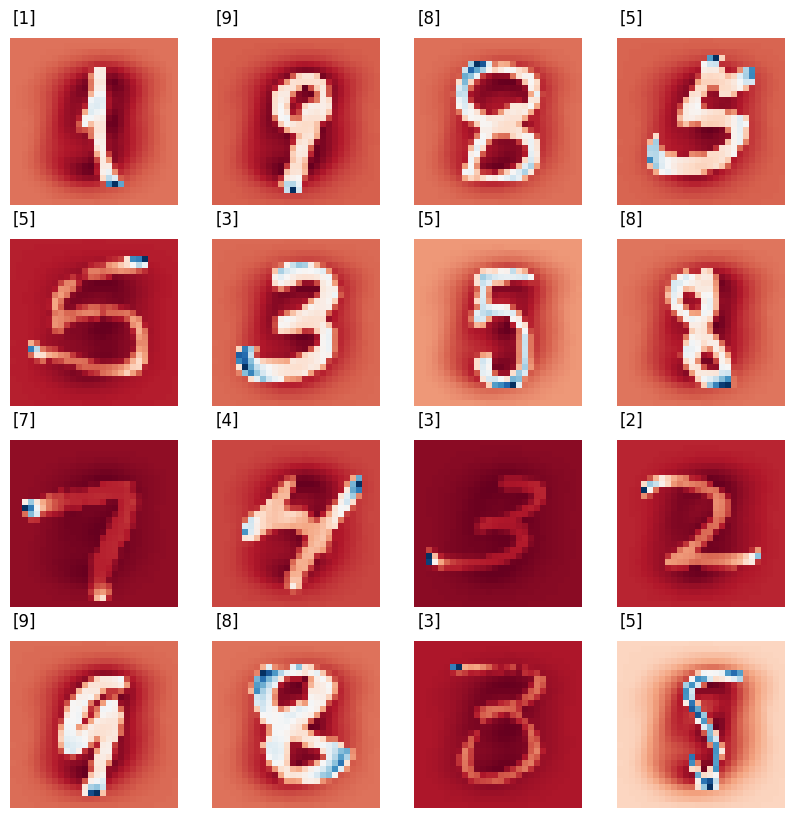

In [208]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    a=random.randint(0,30000)
    images = X_train[a]
    pixels=images.reshape((28,28))
    ax.imshow(pixels,cmap='RdBu')
    ax.axis('off')
    ax.text(0,-3,y_train[a],fontsize=12)
plt.show()

## Building up parts of our classifier

**Activation functions**

In [209]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    cond = z < 0
    ans = np.copy(z)
    ans[cond] = 0
    return ans


def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    soln = np.exp(z)
    divider = np.sum(soln,axis=0,keepdims=True)
    soln = soln/divider
    return soln

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [210]:
def init_params(inp,dense):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    # matrix has the order : w1, b1, w2, b2
    arr = []
    np.random.seed(2)
    w1 = np.random.randn(dense,784) * 1e-2
    # arr.append(w1)
    b1 = np.zeros((dense, 1))
    b2 = np.zeros((10, 1))
    # arr.append(b1)
    np.random.seed(12)
    w2 = np.random.randn(10,dense)* 1e-2
    # arr.append(w2)
    b2 = np.zeros((10,inp))
    # arr.append(b2)
    return w1,b1,w2,b2


**Forward Propagation**

In [211]:
def forward_propg(X, weight,bias):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    #using this function to propogate values forward one layer at a time
    # print(np.shape(bias))
    return (np.dot(weight,X) + bias)


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [212]:
def backward_propg(w1,b1,w2,b2, X, y, a2, a1,lr):
    # lrn_rate = 0.2
    """
    should update the weights and return updated weights
    """
    y_val = np.zeros(np.shape(a2))
    # print(np.shape(a2))
    for i in range(30000):
        y_val[y[i][0]][i] = 1
    dz2 = a2 - y_val
    # dz2 = (-y_val/a2) + (1-y_val)/(1 - a2)
    cond = a1 > 0
    g_z1 = np.copy(a1)
    g_z1[cond] = 1
    m = np.shape(X)[1]
    dw2 = np.dot(dz2,np.transpose(a1))/m
    db2 = np.sum(dz2, axis=1,keepdims=True)/m
    dz1 = np.dot(np.transpose(w2),dz2) * g_z1
    dw1 = (1/m) * np.dot(dz1,np.transpose(X))
    db1 = (1/m) * np.sum(dz1,axis=1,keepdims=True)
    w1 = w1 - lr*dw1
    # print(db1)
    b1 = b1 - lr*db1
    w2 = w2 - lr*dw2
    b2 =b2 - lr*db2
    return w1,b1,w2,b2    

In [213]:
def cost_func(A,y):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    My- Here A 10 * inp matrix of probs predicted
    y --> 10 * inp matrix such that each column has just 1 1 and rest 0
    """
    # print(np.shape(A))
    # print(np.shape(y))
    y_val = np.zeros(np.shape(A))
    for i in range(30000):
        y_val[y[i][0]][i] = 1
    loss = -(y_val*np.log(A))
    return np.sum(loss,keepdims=True)/len(y)
        
    


## Integrate everything

In [214]:
def train(X, y, hidden_nodes, epochs=1000, lr=0.5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    hidden_dim = 512 # replace with your own hidden dimension
    # initialize weights.
    w1,b1,w2,b2 = init_params(np.shape(X)[1],hidden_dim)
    for i in range(epochs):
        # forward propagation
        a1 = relu(forward_propg(X,w1,b1))
        a2 = softmax(forward_propg(a1,w2,b2))
        # print cost at every 100 or so iterations
        if(i % 10 == 0):
            print(cost_func(a2,y))
            # pass
        # backward propagation
        w1,b1,w2,b2 = backward_propg(w1,b1,w2,b2,X,y,a2,a1,lr)
        # lr *= 0.99
    return w1,b1,w2,b2

# print("here") 
# print(np.shape(y_train))
hidden_dim = 512 # replace with your own hidden dimension


In [215]:
def predict(X, w1,b1,w2,b2):
    """
    returns the prediction in [0,9] for each element in X
    """
    return np.transpose(np.argmax(softmax(forward_propg(relu(forward_propg(X,w1,b1)),w2,b2)),axis=0))

In [216]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    accuracy = 0
    for i in range(np.shape(y)[0]):
        if(predictions[i] == y[i]):
            accuracy += 1
    # accuracy = np.sum(ans) * 100 / len(predictions)
    print(accuracy * 100 / np.shape(y)[0])
w1,b1,w2,b2 = train(np.transpose(X_train),y_train,hidden_dim)
my_pred = predict(np.transpose(X_test),w1,b1,w2,b2)
accuracy(my_pred,y_test)


[[2.30710087]]
[[0.61626317]]
[[0.36242632]]
[[0.29520054]]
[[0.25869202]]
[[0.23355207]]
[[0.21428648]]
[[0.19862538]]
[[0.18543235]]
[[0.17405871]]
[[0.164076]]
[[0.15518858]]
[[0.14718462]]
[[0.13992628]]
[[0.1332796]]
[[0.12716873]]
[[0.12151941]]
[[0.11627621]]
[[0.1113911]]
[[0.10682271]]
[[0.10253614]]
[[0.09850308]]
[[0.09470242]]
[[0.09111709]]
[[0.08772429]]
[[0.08450651]]
[[0.08145211]]
[[0.07854754]]
[[0.07578768]]
[[0.07316321]]
[[0.07066539]]
[[0.06828734]]
[[0.06601837]]
[[0.06385248]]
[[0.06178535]]
[[0.0598101]]
[[0.05792125]]
[[0.05611362]]
[[0.05438412]]
[[0.05272828]]
[[0.05113959]]
[[0.04961561]]
[[0.04815261]]
[[0.04674851]]
[[0.04539981]]
[[0.04410465]]
[[0.04285831]]
[[0.04165854]]
[[0.04050337]]
[[0.0393911]]
[[0.03832123]]
[[0.03729096]]
[[0.03629924]]
[[0.03534442]]
[[0.03442359]]
[[0.0335348]]
[[0.0326774]]
[[0.03184952]]
[[0.03104998]]
[[0.03027774]]
[[0.02953139]]
[[0.0288098]]
[[0.02811236]]
[[0.02743827]]
[[0.0267857]]
[[0.0261539]]
[[0.02554242]]
[[0.02

### Save as pickle

In [217]:
# import random

roll_num = "22b0989" # enter ldap


model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': w1, # layer 0 weight (784, z)
    'layer_0_bias': b1, # layer 0 bias (z, 1)
    'layer_1_wt': w2, # layer 1 weight (z, 10)
    'layer_1_bias': b2 # layer 1 bias (10, 1)
}

# # assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
# # assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
# # assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
# # assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)